In [2]:
pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 111.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.2 MB/s eta 0:00:00


In [20]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import pickle
import gensim
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline 
from functools import partial

from sklearn import model_selection
from imblearn.over_sampling  import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix




from tensorflow.keras import models, layers, preprocessing as kprocessing
import transformers



# Pre-processing

In [1]:
import pandas as pd
aita_all = pd.read_csv("datasets/aita_preprocessed.csv")

In [2]:
aita_all.head()

,Unnamed: 0,id,Keywords,timestamp,title,body,verdict,post,Polarity scores,compound,comp_score,post_clean,sentiment
0,0,1ytxov,Communication,1393278651,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,asshole,[AITA] I wrote an explanation in TIL and came ...,"{'neg': 0.137, 'neu': 0.63, 'pos': 0.233, 'com...",0.6808,pos,aita I write explanation til come condescend p...,positive
1,1,1yu29c,Food,1393281184,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",asshole,[AITA] Threw my parent's donuts away My parent...,"{'neg': 0.095, 'neu': 0.713, 'pos': 0.192, 'co...",0.8591,pos,aita throw parent donut away parent diabetic m...,positive
2,2,1yu8hi,Relationship,1393284677,I told a goth girl she looked like a clown.,I was four.,not the asshole,I told a goth girl she looked like a clown. I ...,"{'neg': 0.0, 'neu': 0.706, 'pos': 0.294, 'comp...",0.3612,pos,I tell goth girl look like clown I four,positive
3,3,1yuc78,Relationship,1393286728,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,everyone sucks,[AItA]: Argument I had with another redditor i...,"{'neg': 0.385, 'neu': 0.615, 'pos': 0.0, 'comp...",-0.3612,neg,aita argument I another redditor r himym,negative
4,4,1yugsc,Entertainment,1393289297,AITA Had a disagreement about Les Miserables w...,I love the musical *Les Miserables*. A coworke...,asshole,AITA Had a disagreement about Les Miserables w...,"{'neg': 0.136, 'neu': 0.621, 'pos': 0.243, 'co...",0.8074,pos,aita disagreement les miserable coworker I lov...,positive


In [ ]:
aita_all["verdict_num"] = [0 if verdict =="not the asshole" else 1 if verdict =="asshole" else 2 if verdict == "everyone sucks" else 3 for verdict in aita_all["verdict"]] # encode verdicts

In [ ]:
aita_all.verdict_num.value_counts()

0    67824
1    22519
3    12533
2     5981
Name: verdict_num, dtype: int64

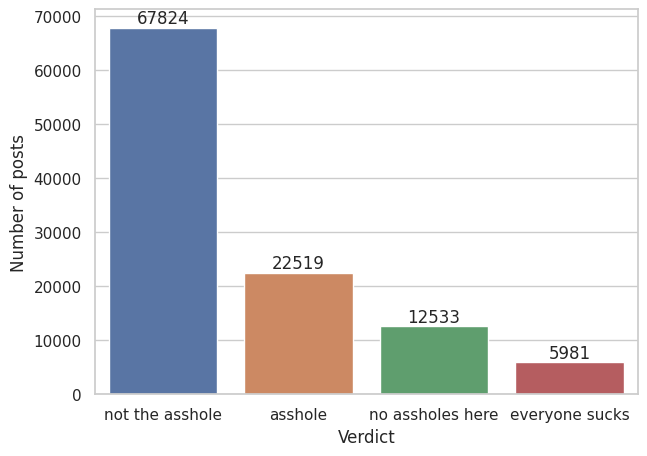

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize = (7,5))
ax = sns.countplot(x = "verdict",data = aita_all, order = aita_all.verdict.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Verdict', ylabel='Number of posts')
plt.show()

In [ ]:
aita_all["post_length"] = aita_all["post_clean"].apply(lambda x: len(x)) # get post length

Text(0.5, 12.44444444444443, 'Length')

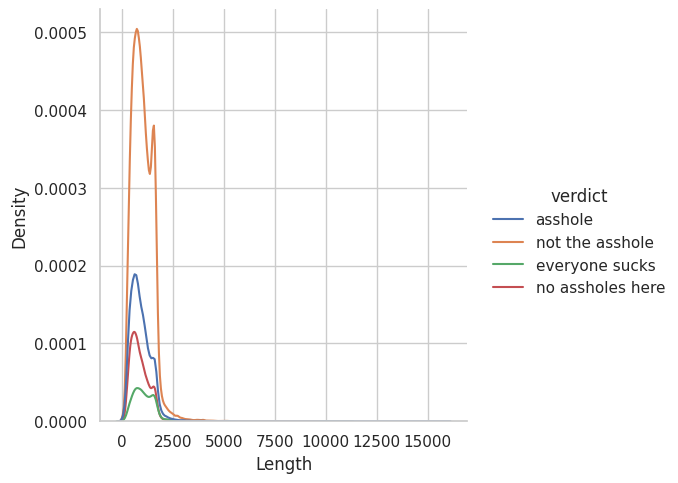

In [ ]:
sns.displot(aita_all[["post_length","verdict"]], x = "post_length", kind = "kde", hue='verdict')
plt.xlabel("Length")

Text(0, 0.5, 'Verdict')

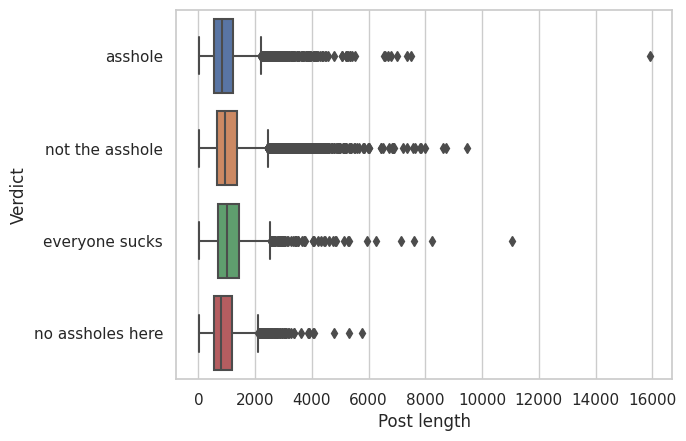

In [ ]:
sns.boxplot(aita_all[["post_length","verdict"]], x = "post_length", y="verdict")
plt.xlabel("Post length")
plt.ylabel("Verdict")

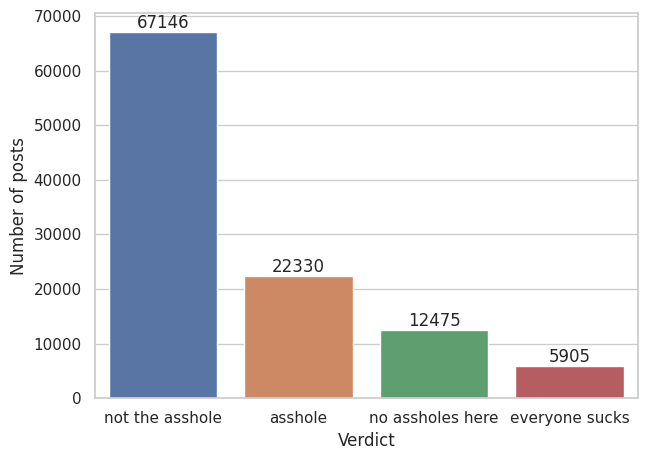

In [ ]:
aita_2500 = aita_all[aita_all["post_length"]<=2500]
sns.set_theme(style="whitegrid")
plt.figure(figsize = (7,5))
ax = sns.countplot(x = "verdict",data = aita_2500, order = aita_2500.verdict.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Verdict', ylabel='Number of posts')
plt.show()

In [ ]:
aita_2500.verdict.value_counts(normalize =True)

not the asshole     0.622552
asshole             0.207035
no assholes here    0.115663
everyone sucks      0.054749
Name: verdict, dtype: float64

In [ ]:
aita_2500["post_tokenised"] = aita_2500["post_clean"].apply(lambda x: x.split(" ")) # tokenise post

<ipython-input-87-35db42eff1a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aita_2500["post_tokenised"] = aita_2500["post_clean"].apply(lambda x: x.split(" "))


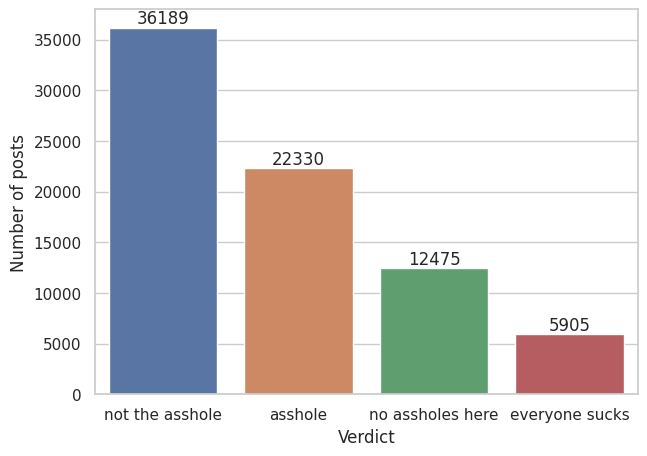

In [ ]:
aita_NTA_1000 = pd.concat([aita_2500[(aita_2500["post_length"]<1000)&(aita_2500["verdict"] =="not the asshole")],
                          aita_2500[aita_2500["verdict"] =="asshole"],
                          aita_2500[aita_2500["verdict"] =="everyone sucks"],
                          aita_2500[aita_2500["verdict"] =="no assholes here"]])
sns.set_theme(style="whitegrid")
plt.figure(figsize = (7,5))
ax = sns.countplot(x = "verdict",data = aita_NTA_1000, order = aita_NTA_1000.verdict.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Verdict', ylabel='Number of posts')
plt.show()

In [ ]:
aita_NTA_1000.verdict.value_counts(normalize =True)

not the asshole     0.470604
asshole             0.290381
no assholes here    0.162226
everyone sucks      0.076789
Name: verdict, dtype: float64

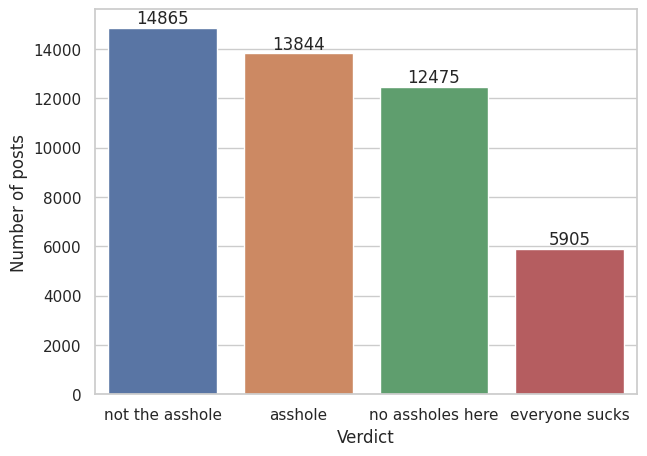

In [ ]:
aita_3_balanced = pd.concat([aita_2500[(aita_2500["post_length"]<600)&(aita_2500["verdict"] =="not the asshole")],
                          aita_2500[(aita_2500["post_length"]<1000)&(aita_2500["verdict"] =="asshole")],
                          aita_2500[aita_2500["verdict"] =="everyone sucks"],
                          aita_2500[aita_2500["verdict"] =="no assholes here"]])
sns.set_theme(style="whitegrid")
plt.figure(figsize = (7,5))
ax = sns.countplot(x = "verdict",data = aita_3_balanced, order = aita_3_balanced.verdict.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Verdict', ylabel='Number of posts')
plt.show()

In [ ]:
aita_3_balanced.verdict.value_counts(normalize =True)

not the asshole     0.315679
asshole             0.293996
no assholes here    0.264924
everyone sucks      0.125401
Name: verdict, dtype: float64

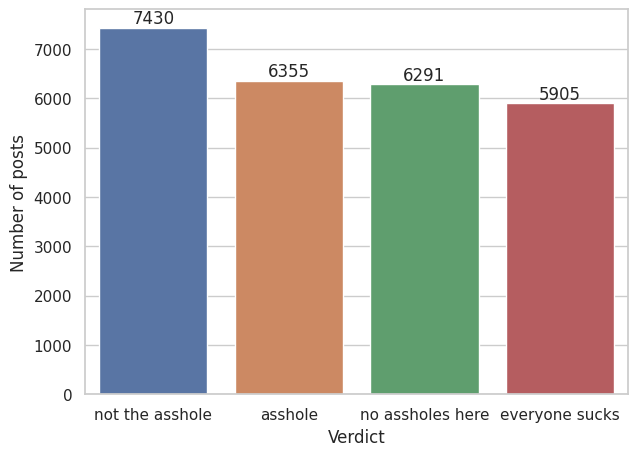

In [ ]:
aita_4_balanced = pd.concat([aita_2500[(aita_2500["post_length"]<450)&(aita_2500["verdict"] =="not the asshole")],
                          aita_2500[(aita_2500["post_length"]<600)&(aita_2500["verdict"] =="asshole")],
                          aita_2500[(aita_2500["post_length"]<800)&(aita_2500["verdict"] =="no assholes here")],
                          aita_2500[aita_2500["verdict"] =="everyone sucks"]])
sns.set_theme(style="whitegrid")
plt.figure(figsize = (7,5))
ax = sns.countplot(x = "verdict",data = aita_4_balanced, order = aita_4_balanced.verdict.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set(xlabel='Verdict', ylabel='Number of posts')
plt.show()

In [ ]:
aita_4_balanced.verdict.value_counts(normalize =True)

not the asshole     0.285978
asshole             0.244602
no assholes here    0.242138
everyone sucks      0.227281
Name: verdict, dtype: float64

# Utils

In [21]:
def remove_links(text):
    return re.sub(r'http\S+', '', text)
def make_lower(text):
    return text.lower()
def remove_punctuation(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) 
    return re.sub(r'[^\w\s]', ' ', text)
def remove_extraspaces(text):
    return re.sub('\s\s+',' ', text)
def clean_text(text):
    text = remove_links(text)
    text = make_lower(text)
    text = remove_extraspaces(text)
    text = remove_punctuation(text)
    return text

## TF-IDF: Preprocessing & Feature Extraction 

In [22]:
def evaluate_model(train, test, pipeline):
  model = pipeline.fit(train["post_clean"], 
                     train["verdict_num"])


  predicted  = model.predict(test["post_clean"])

  classes = np.unique(y_test)
        ## Accuracy, Precision, Recall
  accuracy = accuracy_score(list(y_test), predicted)
  balanced_accuracy = balanced_accuracy_score(list(y_test), predicted)
  print("Accuracy:",  round(accuracy,2))
  print("Balanced accuracy:",  round(balanced_accuracy,2))
  print("Detail:")
  print(classification_report(list(y_test), predicted))
      
  ## Plot confusion matrix
  cm = confusion_matrix(list(y_test), predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  

In [23]:
def get_metrics(model):

  predicted = model.predict(X_test_tfidf)
  classes = np.unique(y_test)
        ## Accuracy, Precision, Recall
  accuracy = accuracy_score(list(y_test), predicted)
  balanced_accuracy = balanced_accuracy_score(list(y_test), predicted)
  print("Accuracy:",  round(accuracy,2))
  print("Balanced accuracy:",  round(balanced_accuracy,2))
  print("Detail:")
  print(classification_report(list(y_test), predicted))
      
  ## Plot confusion matrix
  cm = confusion_matrix(list(y_test), predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)

## Word2Vec

### MLP



In [24]:
def get_X_tokenised_wordvec(X, vocabulary):
  X_vect = np.array([np.array([wordvec.wv[i] for i in ls if i in vocabulary])
                         for ls in X])
  X_vect_avg = [v.mean(axis = 0) if v.size else np.zeros(300, dtype = float) for v in X_vect]
  return X_vect_avg

In [25]:
def create_mlp():
  return MLPClassifier(solver='lbfgs',alpha=1e-5,activation="tanh", hidden_layer_sizes=(50,300,50), random_state=0, max_iter = 500)

In [26]:
def train_test_mlp(model, X_train, X_test, y_train, y_test): 
  verdict_map = {n:label for n,label in 
                    enumerate(np.unique(y_train))}
  inverse_verdict_map = {v:k for k,v in verdict_map.items()}
  y_train = np.array([inverse_verdict_map[y] for y in y_train])
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  classes = np.unique(y_test)
  y_test_array = pd.get_dummies(y_test, drop_first=False).values

  accuracy = accuracy_score(list(y_test), predicted)
  balanced_accuracy = balanced_accuracy_score(list(y_test), predicted)
  
  print("Accuracy:",  round(accuracy,2))
  print("Balanced accuracy:",  round(balanced_accuracy,2))
  
  print("Detail:")
  print(classification_report(list(y_test), predicted))
      

  cm = confusion_matrix(list(y_test), predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  return model, accuracy, balanced_accuracy, cm

### Bi-LSTM

In [27]:
def get_X_padded_sequence(tokenizer, corpus): 
  text2seq= tokenizer.texts_to_sequences(corpus)  
  return kprocessing.sequence.pad_sequences(text2seq, 
                    maxlen=300, padding="post", truncating="post")

In [28]:
def create_bi_lstm(embedding_matrix): # This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
  x_in = layers.Input(shape=(300,))
  x = layers.Embedding(input_dim=embedding_matrix.shape[0],  
                      output_dim=embedding_matrix.shape[1], 
                      weights=[embeddings],
                      input_length=300, trainable=False)(x_in)
  x = layers.Bidirectional(layers.LSTM(units=300, dropout=0.4))(x)

  x = layers.Dense(64, activation='relu')(x)
  y_out = layers.Dense(4, activation='softmax')(x)
  model = models.Model(x_in, y_out)
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

  model.summary()
  return model
  

In [29]:
def train_test_bi_lstm(model, X_train, X_test, y_train, y_test,epochs): # This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
  verdict_map = {n:label for n,label in 
                    enumerate(np.unique(y_train))}
  inverse_verdict_map = {v:k for k,v in verdict_map.items()}
  y_train = np.array([inverse_verdict_map[y] for y in y_train])
  training = model.fit(x=X_train, y=y_train, batch_size=64, 
                    epochs=epochs, 
                    validation_split=0.25)
  predicted_prob = model.predict(X_test)
  predicted = [verdict_map[np.argmax(pred)] for pred in 
              predicted_prob]
  metricss = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metricss:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metricss:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()

  classes = np.unique(y_test)
  y_test_array = pd.get_dummies(y_test, drop_first=False).values

  accuracy = accuracy_score(list(y_test), predicted)
  balanced_accuracy = balanced_accuracy_score(list(y_test), predicted)
  auc = roc_auc_score(list(y_test), predicted_prob, 
                              multi_class="ovr")
  
  print("Accuracy:",  round(accuracy,2))
  print("Balanced accuracy:",  round(balanced_accuracy,2))
  print("Auc:", round(auc,2))

  print("Detail:")
  print(classification_report(list(y_test), predicted))
      
 
  cm = confusion_matrix(list(y_test), predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  return model, accuracy, balanced_accuracy, cm

## DistilBERT model utils

In [30]:
tokenizer_distil = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [48]:
def get_X_tokenised_distilbert(corpus, tokenizer): # This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
    maxlen = 512 
    max_special_characters = int((maxlen-20)/2) # account for unknown and special tokens
    corpus_tokenized = ["[CLS] "+
               " ".join(tokenizer.tokenize(clean_text(text))[:max_special_characters])+
                " [SEP] " for text in corpus]
    masks = [[1]*len(text.split(" ")) + [0]*(maxlen - len(
              text.split(" "))) for text in corpus_tokenized]
        
    txt2seq = [text + " [PAD]"*(maxlen-len(text.split(" "))) if len(text.split(" ")) != maxlen else text for text in corpus_tokenized]

    idx = [tokenizer.convert_tokens_to_ids(sequence.split(" ")) for sequence in txt2seq]
    return [np.asarray(idx, dtype='int64'), 
              np.asarray(masks, dtype='int64')]
   

In [32]:
def get_distil_bert_model(): # This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
    ids = layers.Input((512), dtype="int64")
    masks = layers.Input((512), dtype="int64")

    configuration = transformers.DistilBertConfig.from_pretrained('distilbert-base-uncased')
    configuration.hidden_dropout_prob = 0.4
    configuration.attention_probs_dropout_prob = 0.4

    distil_bert = transformers.TFDistilBertModel.from_pretrained("distilbert-base-uncased", config = configuration) #configure bert from Hugging Face
    distil_bert_transfered = distil_bert(ids, attention_mask = masks)[0]  # transfer learning
    x = layers.GlobalAveragePooling1D()(distil_bert_transfered)
    x = layers.Dense(64, activation="relu")(x)
    y_out = layers.Dense(4, activation='softmax')(x)
    model = models.Model([ids, masks], y_out)
    for layer in model.layers[:3]:
        layer.trainable = False
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [33]:
def train_test_distil_bert(model, aita, X_train, X_test, y_train, y_test,epochs): # This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
    verdict_map = {n:label for n,label in 
                    enumerate(np.unique(y_train))}
    inverse_verdict_map = {v:k for k,v in verdict_map.items()}
    y_train = np.array([inverse_verdict_map[y] for y in y_train])## train
    training = model.fit(x=X_train, y=y_train, batch_size=64, 
                        epochs=epochs, shuffle=True, verbose=1, 
                        validation_split=0.1)## test
    predicted_prob = model.predict(X_test)
    predicted = [verdict_map[np.argmax(pred)] for pred in 
                predicted_prob]
    aita["predicted"] = predicted 
    metricss = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metricss:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metricss:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    accuracy = accuracy_score(list(y_test), predicted)
    balanced_accuracy = balanced_accuracy_score(list(y_test), predicted)
    auc = roc_auc_score(list(y_test), predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Balanced accuracy:",  round(balanced_accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(classification_report(list(y_test), predicted))
        

    cm = confusion_matrix(list(y_test), predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
          yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)
    return model, accuracy, balanced_accuracy, cm

# `aita_2500`

In [ ]:
aita_train, aita_test = train_test_split(aita_2500, test_size = 0.25)
y_train = aita_train["verdict_num"].values
y_test = aita_test["verdict_num"].values

## TF-idf

In [ ]:
aita_train["post_clean"] = aita_train["post_clean"].astype('U')
aita_test["post_clean"] = aita_test["post_clean"].astype('U')

###No SMOTE

In [ ]:
count_vect = CountVectorizer()

X_train_tf = count_vect.fit_transform(aita_train["post_clean"])
X_test_tf = count_vect.transform(aita_test["post_clean"])

In [ ]:
print("Shape of term-frequency matrix:", X_train_tf.shape)

Shape of term-frequency matrix: (80892, 55823)


In [ ]:
tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

In [ ]:
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_logistic.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [ ]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.62
Balanced accuracy: 0.28
Detail:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76     16737
           1       0.38      0.14      0.20      5602
           2       0.33      0.01      0.01      1475
           3       0.33      0.05      0.09      3150

    accuracy                           0.62     26964
   macro avg       0.42      0.28      0.27     26964
weighted avg       0.53      0.62      0.53     26964



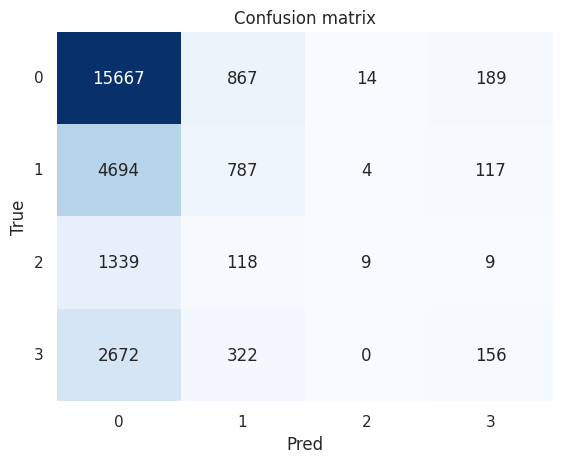

In [ ]:
get_metrics(model_logistic)

Accuracy: 0.62
Balanced accuracy: 0.25
Detail:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77     16737
           1       0.50      0.00      0.00      5602
           2       0.00      0.00      0.00      1475
           3       0.00      0.00      0.00      3150

    accuracy                           0.62     26964
   macro avg       0.28      0.25      0.19     26964
weighted avg       0.49      0.62      0.48     26964



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


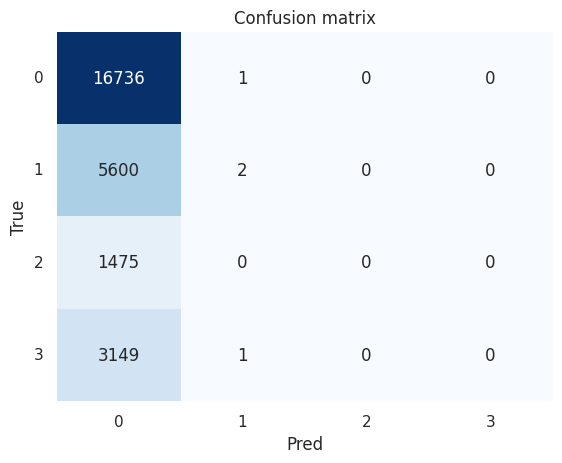

In [ ]:
get_metrics(model_mnb)

### Initialise SMOTE

In [ ]:
evaluate_pipeline = partial(evaluate_model,
                            aita_train,
                            aita_test)

### SMOTE - multinomial bayes

In [ ]:
nb_pipe_smote  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', SMOTE(random_state=42)),
                     ('model',   MultinomialNB())])

Accuracy: 0.37
Balanced accuracy: 0.37
Detail:
              precision    recall  f1-score   support

           0       0.71      0.40      0.51     16737
           1       0.29      0.24      0.26      5602
           2       0.09      0.41      0.15      1475
           3       0.20      0.43      0.28      3150

    accuracy                           0.37     26964
   macro avg       0.33      0.37      0.30     26964
weighted avg       0.53      0.37      0.41     26964



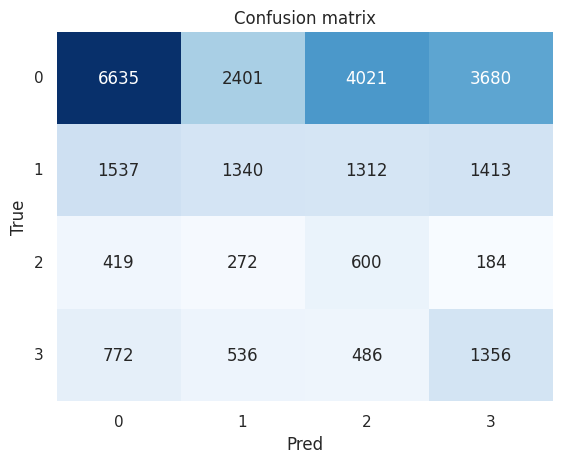

In [ ]:
evaluate_pipeline(nb_pipe_smote)

### SMOTE-Logistic

In [ ]:
nb_pipe_smote  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', SMOTE(random_state=42)),
                     ('model',   LogisticRegression(multi_class='multinomial', solver='lbfgs'))])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.4
Balanced accuracy: 0.37
Detail:
              precision    recall  f1-score   support

           0       0.72      0.42      0.53     16737
           1       0.29      0.33      0.31      5602
           2       0.10      0.30      0.15      1475
           3       0.21      0.42      0.28      3150

    accuracy                           0.40     26964
   macro avg       0.33      0.37      0.32     26964
weighted avg       0.54      0.40      0.44     26964



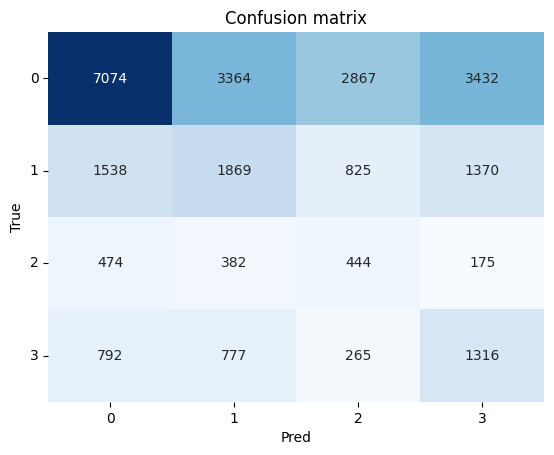

In [ ]:
evaluate_pipeline(nb_pipe_smote)

## Word2Vec

### Train word2vec

In [ ]:
corpus_train = [tokens for tokens in aita_train["post_tokenised"]] # create corpus from training data
corpus_test = [tokens for tokens in aita_test["post_tokenised"]] # create corpus from testing data

In [ ]:
wordvec = gensim.models.word2vec.Word2Vec(corpus_train, vector_size=300, min_count=1, sg=1) #train wordvec

### MLP classifier


In [ ]:
X_train = aita_train["post_tokenised"]
X_test = aita_test["post_tokenised"]
vocabulary = set(wordvec.wv.index_to_key)

# average vectors
X_train_avg = get_X_tokenised_wordvec(X_train, vocabulary)
X_test_avg = get_X_tokenised_wordvec(X_test, vocabulary)

<ipython-input-6-bc14ae4f2e51>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_vect = np.array([np.array([wordvec.wv[i] for i in ls if i in vocabulary])


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy: 0.62
Balanced accuracy: 0.27
Detail:
              precision    recall  f1-score   support

           0       0.63      0.98      0.77     16737
           1       0.43      0.06      0.11      5602
           2       0.25      0.00      0.00      1475
           3       0.35      0.03      0.05      3150

    accuracy                           0.62     26964
   macro avg       0.42      0.27      0.23     26964
weighted avg       0.54      0.62      0.51     26964



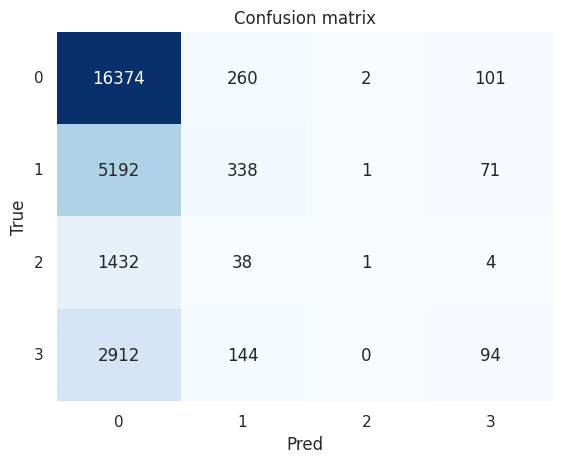

In [ ]:
mlp = create_mlp()
mlp, accuracy, balanced_accuracy, cm = train_test_mlp(mlp, X_train_avg, X_test_avg, y_train, y_test)

### Tokenisation + embedding matrix


In [ ]:
# This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # initialise tensorflow tokenizer
tokenizer.fit_on_texts(corpus_train) # fit tokenizer on training corpus
vocabulary = tokenizer.word_index # generate vocabulary

# get training and testing data
X_train = get_X_padded_sequence(tokenizer, corpus_train)
X_test = get_X_padded_sequence(tokenizer, corpus_test)

# generate embedding matrix
embedding_matrix = np.zeros((len(vocabulary)+1, 300))
for word,idx in vocabulary.items():
    if word in wordvec.wv:
        embedding_matrix[idx] =  wordvec.wv[word]

### Bidirectional LSTM

In [ ]:
model = create_bi_lstm(embedding_matrix)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 300)          4634100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                38464     
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6,115,224
Trainable params: 1,481,124
Non-trainable params: 4,634,100
_________________________________________

Epoch 1/5
77/77 [==============================] - 7s 40ms/step - loss: 1.0519 - accuracy: 0.6190 - val_loss: 1.0073 - val_accuracy: 0.6324
Epoch 2/5
77/77 [==============================] - 2s 29ms/step - loss: 1.0353 - accuracy: 0.6244 - val_loss: 1.0170 - val_accuracy: 0.6324
Epoch 3/5
77/77 [==============================] - 2s 30ms/step - loss: 1.0363 - accuracy: 0.6244 - val_loss: 1.0061 - val_accuracy: 0.6324
Epoch 4/5
77/77 [==============================] - 2s 30ms/step - loss: 1.0357 - accuracy: 0.6236 - val_loss: 1.0071 - val_accuracy: 0.6324
Epoch 5/5
843/843 [==============================] - 9s 10ms/step


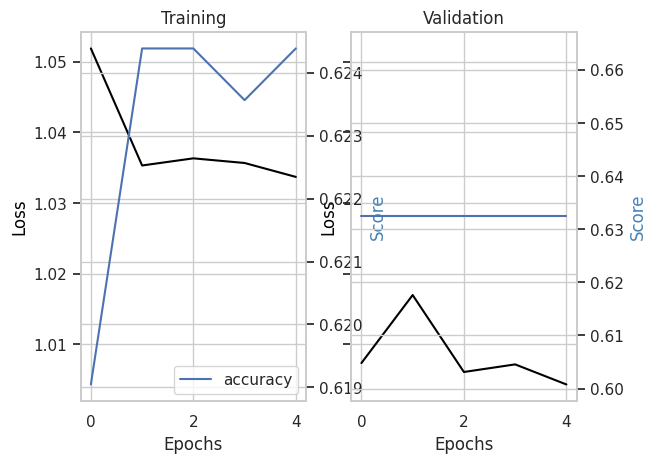

Accuracy: 0.62
Balanced accuracy: 0.25
Auc: 0.52
Detail:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77     16737
           1       0.00      0.00      0.00      5602
           2       0.00      0.00      0.00      1475
           3       0.00      0.00      0.00      3150

    accuracy                           0.62     26964
   macro avg       0.16      0.25      0.19     26964
weighted avg       0.39      0.62      0.48     26964



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


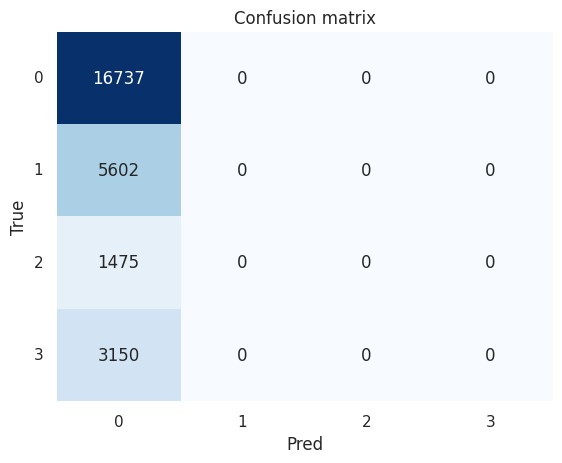

In [ ]:
model, accuracy, balanced_accuracy, cm = train_test_bi_lstm(model, X_train, X_test, y_train, y_test, epochs = 5)

## DistilBERT

In [42]:
aita_train["post_clean_bert"] = aita_train["post"].apply(lambda x: clean_text(x))
aita_test["post_clean_bert"] = aita_test["post"].apply(lambda x: clean_text(x))

In [49]:
X_train = get_X_tokenised_distilbert(aita_train["post_clean_bert"], tokenizer_distil)
X_test = get_X_tokenised_distilbert(aita_test["post_clean_bert"], tokenizer_distil)

In [ ]:
distilbert_model= get_distil_bert_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 512, 768),                                                   
                                 hidden_states=None                                         

Epoch 1/5
1138/1138 [==============================] - 559s 485ms/step - loss: 0.9947 - accuracy: 0.6230 - val_loss: 0.9900 - val_accuracy: 0.6224
Epoch 2/5
1138/1138 [==============================] - 550s 483ms/step - loss: 0.9829 - accuracy: 0.6234 - val_loss: 0.9837 - val_accuracy: 0.6220
Epoch 3/5
1138/1138 [==============================] - 550s 483ms/step - loss: 0.9797 - accuracy: 0.6235 - val_loss: 0.9786 - val_accuracy: 0.6215
Epoch 4/5
1138/1138 [==============================] - 550s 483ms/step - loss: 0.9778 - accuracy: 0.6235 - val_loss: 0.9842 - val_accuracy: 0.6220
Epoch 5/5
843/843 [==============================] - 160s 188ms/step


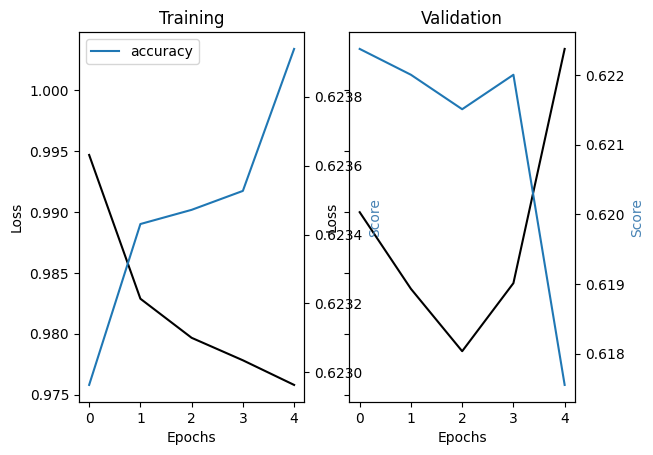

Accuracy: 0.62
Balanced accuracy: 0.27
Auc: 0.65
Detail:
              precision    recall  f1-score   support

           0       0.63      0.97      0.76     16737
           1       0.37      0.04      0.07      5602
           2       0.00      0.00      0.00      1475
           3       0.30      0.07      0.12      3150

    accuracy                           0.62     26964
   macro avg       0.33      0.27      0.24     26964
weighted avg       0.50      0.62      0.50     26964



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<keras.engine.functional.Functional at 0x7f7c1b06f010>,
 0.6161919596499036,
 0.26945342134237077,
 array([[16164,   245,     0,   328],
        [ 5192,   224,     0,   186],
        [ 1432,    35,     0,     8],
        [ 2819,   104,     0,   227]]))

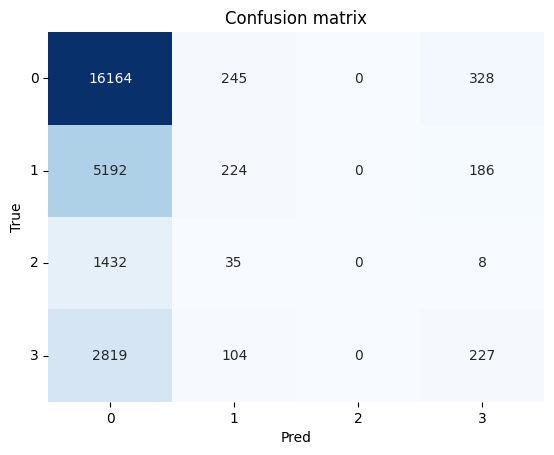

In [ ]:
train_test_distil_bert(distilbert_model, X_train, X_test, y_train, y_test, epochs = 5)

# `aita_NTA_1000`

In [ ]:
aita_train, aita_test = train_test_split(aita_NTA_1000, test_size = 0.25)
y_train = aita_train["verdict_num"].values
y_test = aita_test["verdict_num"].values

## TF-idf

In [ ]:
aita_train["post_clean"] = aita_train["post_clean"].astype('U')
aita_test["post_clean"] = aita_test["post_clean"].astype('U')

In [ ]:
count_vect = CountVectorizer()
X_train_tf = count_vect.fit_transform(aita_train["post_clean"])
X_test_tf = count_vect.transform(aita_test["post_clean"])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

In [ ]:
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_logistic.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [ ]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.51
Balanced accuracy: 0.34
Detail:
              precision    recall  f1-score   support

           0       0.56      0.80      0.66      9057
           1       0.41      0.37      0.39      5460
           2       0.38      0.05      0.10      1475
           3       0.41      0.15      0.22      3233

    accuracy                           0.51     19225
   macro avg       0.44      0.34      0.34     19225
weighted avg       0.48      0.51      0.46     19225



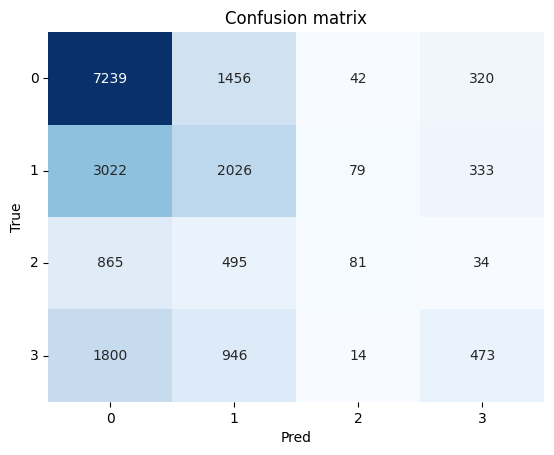

In [ ]:
get_metrics(model_logistic)

Accuracy: 0.47
Balanced accuracy: 0.25
Detail:
              precision    recall  f1-score   support

           0       0.47      0.99      0.64      9057
           1       0.42      0.02      0.04      5460
           2       0.00      0.00      0.00      1475
           3       0.00      0.00      0.00      3233

    accuracy                           0.47     19225
   macro avg       0.22      0.25      0.17     19225
weighted avg       0.34      0.47      0.31     19225



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


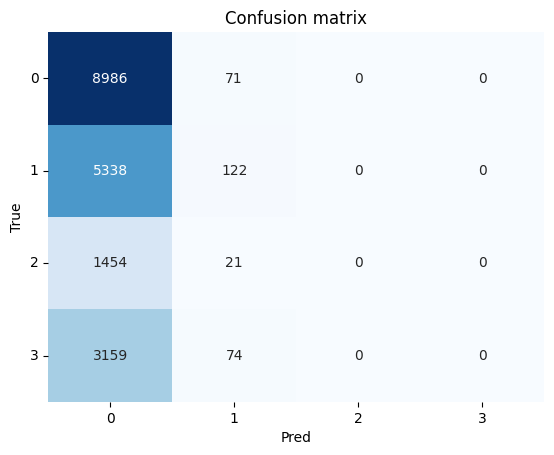

In [ ]:
get_metrics(model_mnb)

## Word2Vec

### Train word2vec

In [ ]:
corpus_train = [tokens for tokens in aita_train["post_tokenised"]] # create corpus from training data
corpus_test = [tokens for tokens in aita_test["post_tokenised"]] # create corpus from testing data

In [ ]:
wordvec = gensim.models.word2vec.Word2Vec(corpus_train, vector_size=300, min_count=1, sg=1) #train wordvec

### MLP classifier


In [ ]:
X_train = aita_train["post_tokenised"]
X_test = aita_test["post_tokenised"]
vocabulary = set(wordvec.wv.index_to_key)
X_train_avg = get_X_tokenised_wordvec(X_train, vocabulary)
X_test_avg = get_X_tokenised_wordvec(X_test, vocabulary)

<ipython-input-6-bc14ae4f2e51>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_vect = np.array([np.array([wordvec.wv[i] for i in ls if i in vocabulary])


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy: 0.51
Balanced accuracy: 0.33
Detail:
              precision    recall  f1-score   support

           0       0.55      0.83      0.67      9057
           1       0.41      0.34      0.37      5460
           2       0.30      0.02      0.04      1475
           3       0.43      0.13      0.20      3233

    accuracy                           0.51     19225
   macro avg       0.42      0.33      0.32     19225
weighted avg       0.47      0.51      0.46     19225



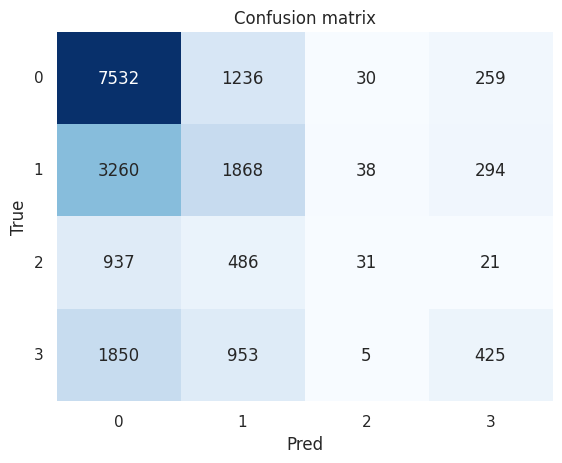

In [ ]:
mlp = create_mlp()
mlp, accuracy, balanced_accuracy, cm = train_test_mlp(mlp, X_train_avg, X_test_avg, y_train, y_test)

### Tokenisation + embedding matrix


In [ ]:
# This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # initialise tensorflow tokenizer
tokenizer.fit_on_texts(corpus_train) # fit tokenizer on training corpus
vocabulary = tokenizer.word_index # generate vocabulary

# get training and testing data
X_train = get_X_padded_sequence(tokenizer, corpus_train)
X_test = get_X_padded_sequence(tokenizer, corpus_test)

# generate embedding matrix
embedding_matrix = np.zeros((len(vocabulary)+1, 300))
for word,idx in vocabulary.items():
    if word in wordvec.wv:
        embedding_matrix[idx] =  wordvec.wv[word]

### Bidirectional LSTM

In [ ]:
model = create_bi_lstm(embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          13407300  
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                38464     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 14,888,424
Trainable params: 1,481,124
Non-trainable params: 13,407,300
_________________________________________

Epoch 1/5
676/676 [==============================] - 31s 32ms/step - loss: 1.0834 - accuracy: 0.5515 - val_loss: 1.0464 - val_accuracy: 0.5660
Epoch 2/5
676/676 [==============================] - 20s 30ms/step - loss: 1.0408 - accuracy: 0.5712 - val_loss: 1.0615 - val_accuracy: 0.5616
Epoch 3/5
676/676 [==============================] - 20s 30ms/step - loss: 1.0271 - accuracy: 0.5745 - val_loss: 1.0188 - val_accuracy: 0.5720
Epoch 4/5
676/676 [==============================] - 20s 30ms/step - loss: 1.0115 - accuracy: 0.5763 - val_loss: 1.0109 - val_accuracy: 0.5757
Epoch 5/5
601/601 [==============================] - 7s 10ms/step


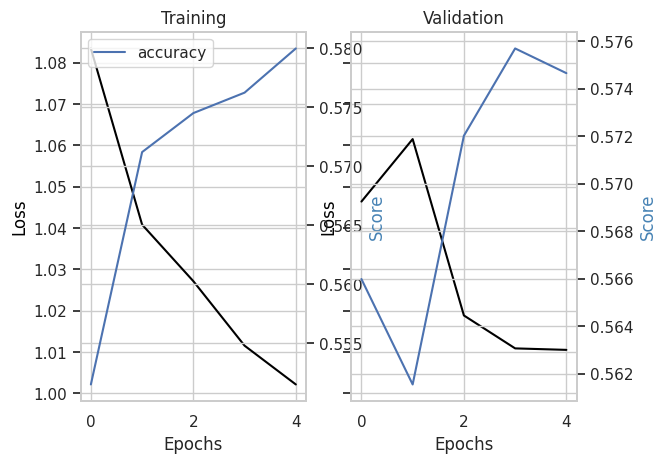

Accuracy: 0.58
Balanced accuracy: 0.36
Auc: 0.74
Detail:
              precision    recall  f1-score   support

           0       0.60      0.94      0.74      9057
           1       0.49      0.41      0.45      5460
           2       0.52      0.02      0.03      1475
           3       0.55      0.07      0.13      3233

    accuracy                           0.58     19225
   macro avg       0.54      0.36      0.34     19225
weighted avg       0.56      0.58      0.50     19225



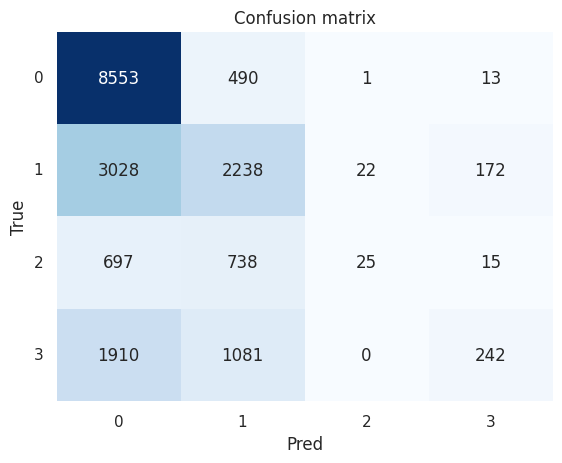

In [ ]:
model, accuracy, balanced_accuracy, cm = train_test_bi_lstm(model, X_train, X_test, y_train, y_test, epochs = 5)

## DistilBERT

In [ ]:
aita_train["post_clean_bert"] = aita_train["post"].apply(lambda x: clean_text(x))
aita_test["post_clean_bert"] = aita_test["post"].apply(lambda x: clean_text(x))

In [ ]:
X_train = get_X_tokenised_distilbert(aita_train["post_clean"], tokenizer_distil)
X_test = get_X_tokenised_distilbert(aita_test["post_clean"], tokenizer_distil)

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
distilbert_model= get_distil_bert_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

Epoch 1/5
812/812 [==============================] - 381s 456ms/step - loss: 1.0794 - accuracy: 0.5555 - val_loss: 1.0494 - val_accuracy: 0.5629
Epoch 2/5
812/812 [==============================] - 368s 453ms/step - loss: 1.0357 - accuracy: 0.5688 - val_loss: 1.0317 - val_accuracy: 0.5674
Epoch 3/5
812/812 [==============================] - 375s 462ms/step - loss: 1.0231 - accuracy: 0.5715 - val_loss: 1.0329 - val_accuracy: 0.5692
Epoch 4/5
812/812 [==============================] - 367s 452ms/step - loss: 1.0179 - accuracy: 0.5737 - val_loss: 1.0307 - val_accuracy: 0.5685
Epoch 5/5
601/601 [==============================] - 116s 189ms/step


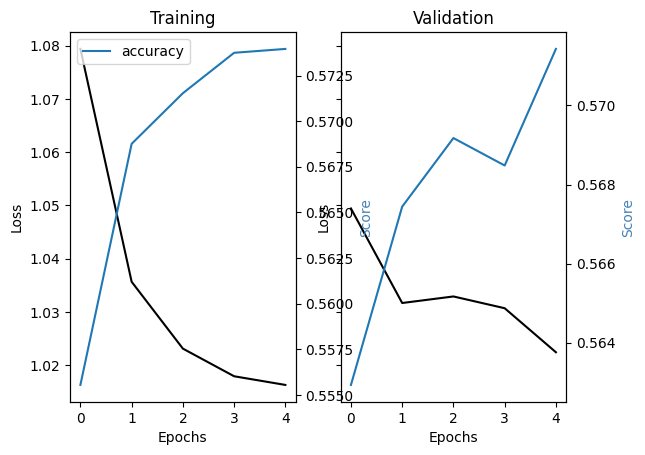

Accuracy: 0.57
Balanced accuracy: 0.35
Auc: 0.72
Detail:
              precision    recall  f1-score   support

           0       0.59      0.97      0.73      9057
           1       0.52      0.37      0.43      5460
           2       0.43      0.01      0.03      1475
           3       0.49      0.07      0.12      3233

    accuracy                           0.57     19225
   macro avg       0.51      0.35      0.33     19225
weighted avg       0.54      0.57      0.49     19225



(<keras.engine.functional.Functional at 0x7f7c28f44610>,
 0.5731599479843953,
 0.35441843130299233,
 array([[8764,  220,    0,   73],
        [3278, 2020,   22,  140],
        [ 788,  656,   20,   11],
        [2018,  996,    4,  215]]))

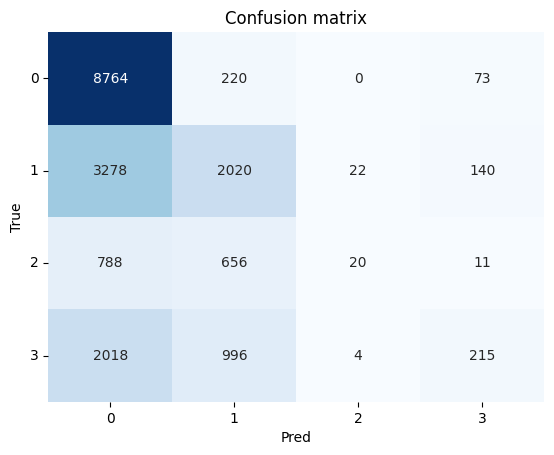

In [ ]:
train_test_distil_bert(distilbert_model, X_train, X_test, y_train, y_test, epochs = 5)

# `aita_3_balanced`

In [ ]:
aita_train, aita_test = train_test_split(aita_3_balanced, test_size = 0.25)
y_train = aita_train["verdict_num"].values
y_test = aita_test["verdict_num"].values

## TF-idf

In [ ]:
aita_train["post_clean"] = aita_train["post_clean"].astype('U')
aita_test["post_clean"] = aita_test["post_clean"].astype('U')

In [ ]:
count_vect = CountVectorizer()
X_train_tf = count_vect.fit_transform(aita_train["post_clean"])
X_test_tf = count_vect.transform(aita_test["post_clean"])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

In [ ]:
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_logistic.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [ ]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.49
Balanced accuracy: 0.47
Detail:
              precision    recall  f1-score   support

           0       0.54      0.63      0.58      3777
           1       0.40      0.38      0.39      3437
           2       0.53      0.32      0.40      1454
           3       0.50      0.54      0.52      3105

    accuracy                           0.49     11773
   macro avg       0.49      0.47      0.47     11773
weighted avg       0.49      0.49      0.49     11773



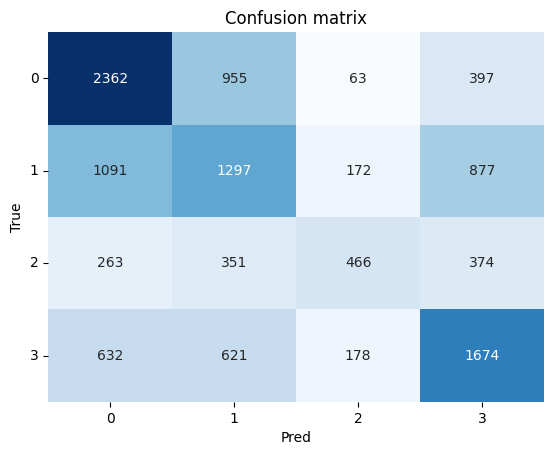

In [ ]:
get_metrics(model_logistic)

Accuracy: 0.42
Balanced accuracy: 0.36
Detail:
              precision    recall  f1-score   support

           0       0.44      0.54      0.49      3777
           1       0.36      0.36      0.36      3437
           2       0.00      0.00      0.00      1454
           3       0.44      0.52      0.48      3105

    accuracy                           0.42     11773
   macro avg       0.31      0.36      0.33     11773
weighted avg       0.36      0.42      0.39     11773



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


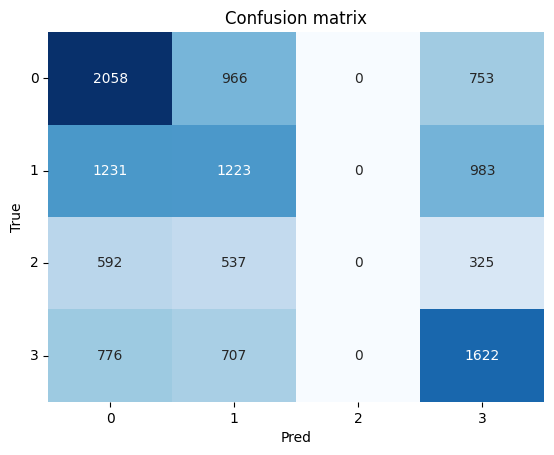

In [ ]:
get_metrics(model_mnb)

## Word2Vec

### Train word2vec

In [ ]:
corpus_train = [tokens for tokens in aita_train["post_tokenised"]] # create corpus from training data
corpus_test = [tokens for tokens in aita_test["post_tokenised"]] # create corpus from testing data

In [ ]:
wordvec = gensim.models.word2vec.Word2Vec(corpus_train, vector_size=300, min_count=1, sg=1) #train wordvec

### MLP classifier


In [ ]:
X_train = aita_train["post_tokenised"]
X_test = aita_test["post_tokenised"]
vocabulary = set(wordvec.wv.index_to_key)
X_train_avg = get_X_tokenised_wordvec(X_train, vocabulary)
X_test_avg = get_X_tokenised_wordvec(X_test, vocabulary)

<ipython-input-6-bc14ae4f2e51>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_vect = np.array([np.array([wordvec.wv[i] for i in ls if i in vocabulary])


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy: 0.49
Balanced accuracy: 0.46
Detail:
              precision    recall  f1-score   support

           0       0.53      0.68      0.59      3777
           1       0.41      0.36      0.38      3437
           2       0.47      0.32      0.38      1454
           3       0.53      0.49      0.51      3105

    accuracy                           0.49     11773
   macro avg       0.48      0.46      0.47     11773
weighted avg       0.49      0.49      0.48     11773



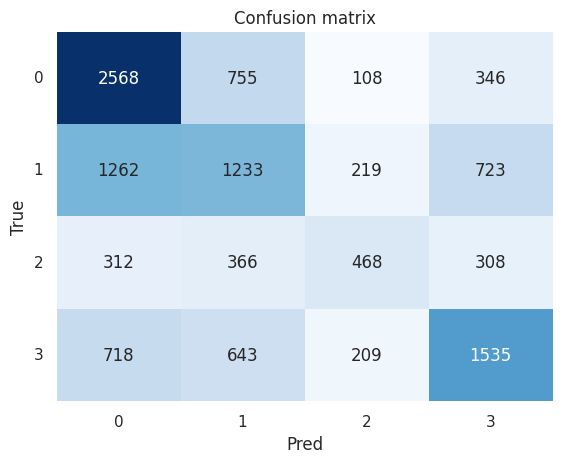

In [ ]:
mlp = create_mlp()
mlp, accuracy, balanced_accuracy, cm = train_test_mlp(mlp, X_train_avg, X_test_avg, y_train, y_test)

### Tokenisation + embedding matrix


In [ ]:
# This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # initialise tensorflow tokenizer
tokenizer.fit_on_texts(corpus_train) # fit tokenizer on training corpus
vocabulary = tokenizer.word_index # generate vocabulary

# get training and testing data
X_train = get_X_padded_sequence(tokenizer, corpus_train)
X_test = get_X_padded_sequence(tokenizer, corpus_test)

# generate embedding matrix
embedding_matrix = np.zeros((len(vocabulary)+1, 300))
for word,idx in vocabulary.items():
    if word in wordvec.wv:
        embedding_matrix[idx] =  wordvec.wv[word]

### Bidirectional LSTM

In [ ]:
model = create_bi_lstm(embedding_matrix)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 300)          10238100  
                                                                 
 bidirectional_1 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                38464     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 11,719,224
Trainable params: 1,481,124
Non-trainable params: 10,238,100
_______________________________________

Epoch 1/5
414/414 [==============================] - 17s 32ms/step - loss: 1.1149 - accuracy: 0.4829 - val_loss: 0.9994 - val_accuracy: 0.5526
Epoch 2/5
414/414 [==============================] - 12s 30ms/step - loss: 1.0061 - accuracy: 0.5496 - val_loss: 1.0027 - val_accuracy: 0.5496
Epoch 3/5
414/414 [==============================] - 12s 30ms/step - loss: 0.9921 - accuracy: 0.5573 - val_loss: 0.9746 - val_accuracy: 0.5633
Epoch 4/5
414/414 [==============================] - 12s 30ms/step - loss: 0.9772 - accuracy: 0.5664 - val_loss: 0.9859 - val_accuracy: 0.5527
Epoch 5/5
368/368 [==============================] - 4s 10ms/step


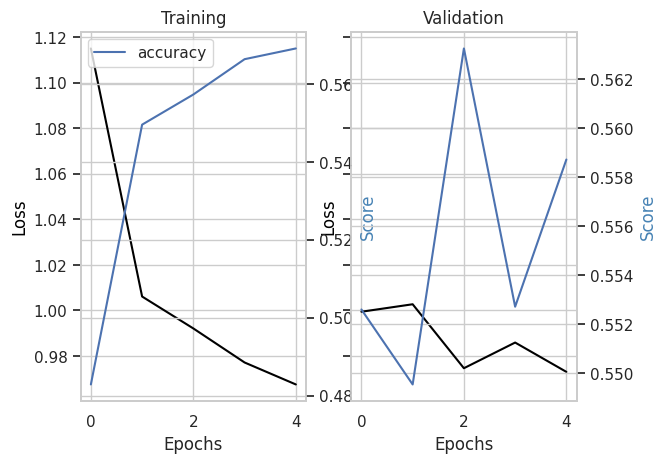

Accuracy: 0.58
Balanced accuracy: 0.52
Auc: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.56      0.97      0.71      3777
           1       0.56      0.40      0.47      3437
           2       0.73      0.25      0.38      1454
           3       0.61      0.45      0.52      3105

    accuracy                           0.58     11773
   macro avg       0.62      0.52      0.52     11773
weighted avg       0.60      0.58      0.55     11773



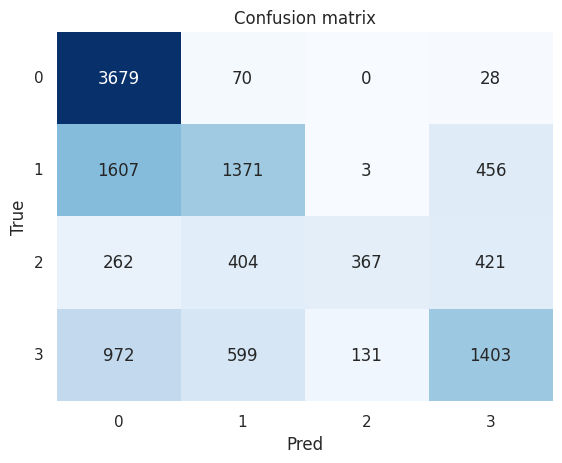

In [ ]:
model, accuracy, balanced_accuracy, cm = train_test_bi_lstm(model, X_train, X_test, y_train, y_test, epochs = 5)

## DistilBERT

In [ ]:
aita_train["post_clean_bert"] = aita_train["post"].apply(lambda x: clean_text(x))
aita_test["post_clean_bert"] = aita_test["post"].apply(lambda x: clean_text(x))

In [ ]:
X_train = get_X_tokenised_distilbert(aita_train["post_clean"], tokenizer_distil)
X_test = get_X_tokenised_distilbert(aita_test["post_clean"], tokenizer_distil)

In [ ]:
distilbert_model= get_distil_bert_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

Epoch 1/5
497/497 [==============================] - 234s 452ms/step - loss: 1.0689 - accuracy: 0.5226 - val_loss: 1.0137 - val_accuracy: 0.5555
Epoch 2/5
497/497 [==============================] - 223s 450ms/step - loss: 1.0007 - accuracy: 0.5561 - val_loss: 0.9940 - val_accuracy: 0.5654
Epoch 3/5
497/497 [==============================] - 223s 449ms/step - loss: 0.9841 - accuracy: 0.5635 - val_loss: 0.9846 - val_accuracy: 0.5572
Epoch 4/5
497/497 [==============================] - 224s 450ms/step - loss: 0.9715 - accuracy: 0.5682 - val_loss: 0.9730 - val_accuracy: 0.5725
Epoch 5/5
368/368 [==============================] - 71s 188ms/step


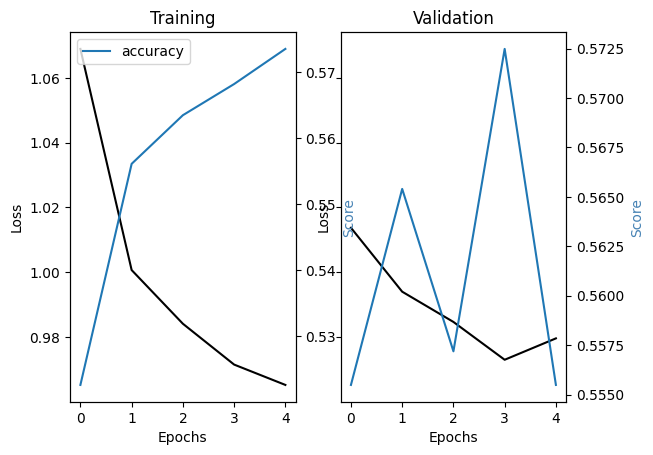

Accuracy: 0.58
Balanced accuracy: 0.53
Auc: 0.8
Detail:
              precision    recall  f1-score   support

           0       0.58      0.91      0.71      3777
           1       0.56      0.37      0.45      3437
           2       0.67      0.30      0.41      1454
           3       0.57      0.54      0.55      3105

    accuracy                           0.58     11773
   macro avg       0.59      0.53      0.53     11773
weighted avg       0.58      0.58      0.56     11773



(<keras.engine.functional.Functional at 0x7f95a7cef3a0>,
 0.5788668988363204,
 0.5295758605194613,
 array([[3424,  212,    1,  140],
        [1414, 1279,   46,  698],
        [ 224,  350,  436,  444],
        [ 807,  450,  172, 1676]]))

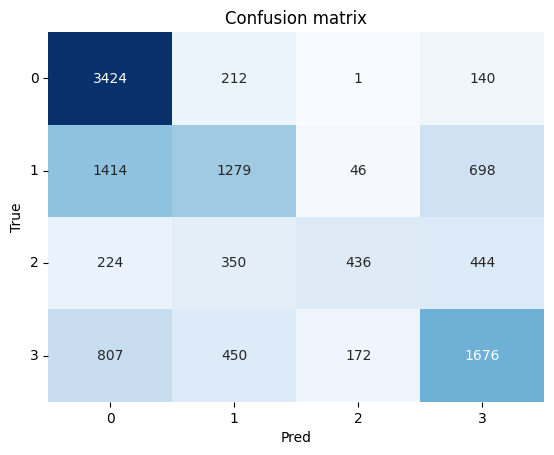

In [ ]:
train_test_distil_bert(distilbert_model, X_train, X_test, y_train, y_test, epochs = 5)

# `aita_4_balanced`

In [ ]:
aita_train, aita_test = train_test_split(aita_4_balanced, test_size = 0.25)
y_train = aita_train["verdict_num"].values
y_test = aita_test["verdict_num"].values

## TF-idf

In [ ]:
aita_train["post_clean"] = aita_train["post_clean"].astype('U')
aita_test["post_clean"] = aita_test["post_clean"].astype('U')

In [ ]:
count_vect = CountVectorizer()
X_train_tf = count_vect.fit_transform(aita_train["post_clean"])
X_test_tf = count_vect.transform(aita_test["post_clean"])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_tf)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

In [ ]:
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_logistic.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [ ]:
model_mnb = MultinomialNB()
model_mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 0.5
Balanced accuracy: 0.5
Detail:
              precision    recall  f1-score   support

           0       0.47      0.58      0.52      1830
           1       0.37      0.28      0.32      1639
           2       0.68      0.69      0.69      1446
           3       0.47      0.46      0.46      1581

    accuracy                           0.50      6496
   macro avg       0.50      0.50      0.50      6496
weighted avg       0.49      0.50      0.49      6496



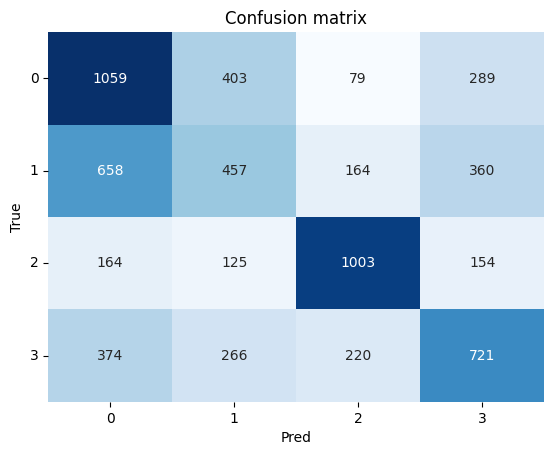

In [ ]:
get_metrics(model_logistic)

Accuracy: 0.41
Balanced accuracy: 0.42
Detail:
              precision    recall  f1-score   support

           0       0.41      0.54      0.47      1830
           1       0.40      0.06      0.10      1639
           2       0.41      0.72      0.52      1446
           3       0.42      0.36      0.39      1581

    accuracy                           0.41      6496
   macro avg       0.41      0.42      0.37      6496
weighted avg       0.41      0.41      0.37      6496



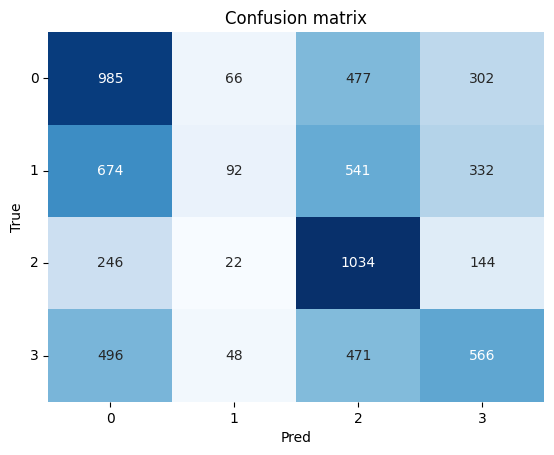

In [ ]:
get_metrics(model_mnb)

## Word2Vec

### Train word2vec

In [ ]:
corpus_train = [tokens for tokens in aita_train["post_tokenised"]] # create corpus from training data
corpus_test = [tokens for tokens in aita_test["post_tokenised"]] # create corpus from testing data

In [ ]:
wordvec = gensim.models.word2vec.Word2Vec(corpus_train, vector_size=300, min_count=1, sg=1) #train wordvec

### MLP classifier


In [ ]:
X_train = aita_train["post_tokenised"]
X_test = aita_test["post_tokenised"]
vocabulary = set(wordvec.wv.index_to_key)
X_train_avg = get_X_tokenised_wordvec(X_train, vocabulary)
X_test_avg = get_X_tokenised_wordvec(X_test, vocabulary)

<ipython-input-6-bc14ae4f2e51>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_vect = np.array([np.array([wordvec.wv[i] for i in ls if i in vocabulary])


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Accuracy: 0.49
Balanced accuracy: 0.49
Detail:
              precision    recall  f1-score   support

           0       0.47      0.63      0.54      1830
           1       0.39      0.23      0.29      1639
           2       0.61      0.68      0.64      1446
           3       0.46      0.41      0.43      1581

    accuracy                           0.49      6496
   macro avg       0.48      0.49      0.48      6496
weighted avg       0.48      0.49      0.47      6496



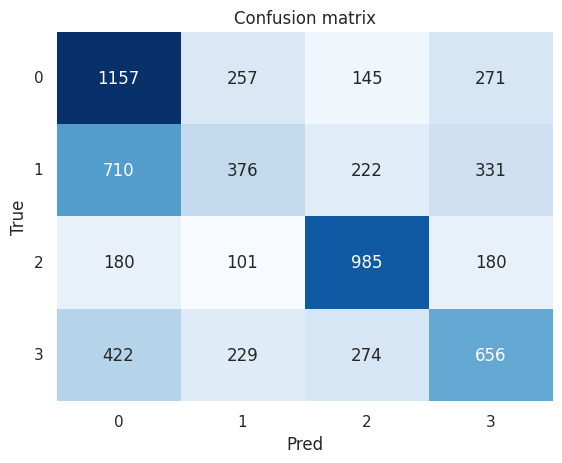

In [ ]:
mlp = create_mlp()
mlp, accuracy, balanced_accuracy, cm = train_test_mlp(mlp, X_train_avg, X_test_avg, y_train, y_test)

### Tokenisation + embedding matrix


In [ ]:
# This code has been adapted from the following blog https://resources.experfy.com/ai-ml/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert/
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # initialise tensorflow tokenizer
tokenizer.fit_on_texts(corpus_train) # fit tokenizer on training corpus
vocabulary = tokenizer.word_index # generate vocabulary

# get training and testing data
X_train = get_X_padded_sequence(tokenizer, corpus_train)
X_test = get_X_padded_sequence(tokenizer, corpus_test)

# generate embedding matrix
embedding_matrix = np.zeros((len(vocabulary)+1, 300))
for word,idx in vocabulary.items():
    if word in wordvec.wv:
        embedding_matrix[idx] =  wordvec.wv[word]

### Bidirectional LSTM

In [ ]:
model = create_bi_lstm(embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 300)          7401900   
                                                                 
 bidirectional (Bidirectiona  (None, 600)              1442400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                38464     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 8,883,024
Trainable params: 1,481,124
Non-trainable params: 7,401,900
___________________________________________

Epoch 1/5
229/229 [==============================] - 12s 34ms/step - loss: 1.1525 - accuracy: 0.4482 - val_loss: 0.8829 - val_accuracy: 0.6170
Epoch 2/5
229/229 [==============================] - 7s 30ms/step - loss: 0.8919 - accuracy: 0.6037 - val_loss: 0.8607 - val_accuracy: 0.6108
Epoch 3/5
229/229 [==============================] - 7s 30ms/step - loss: 0.8657 - accuracy: 0.6176 - val_loss: 0.8538 - val_accuracy: 0.6201
Epoch 4/5
229/229 [==============================] - 7s 30ms/step - loss: 0.8602 - accuracy: 0.6179 - val_loss: 0.8529 - val_accuracy: 0.6232
Epoch 5/5
203/203 [==============================] - 3s 10ms/step


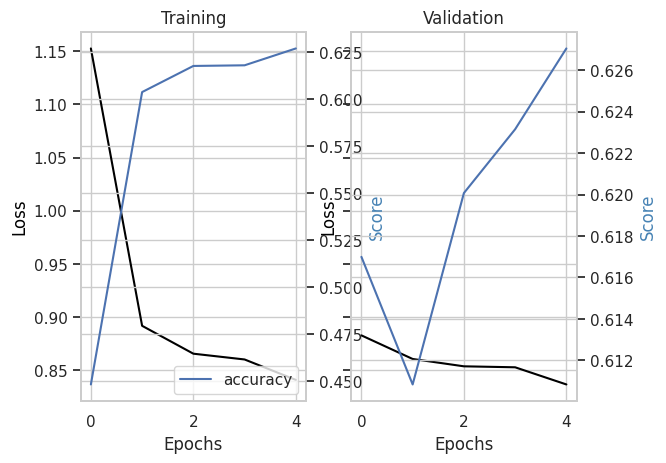

Accuracy: 0.62
Balanced accuracy: 0.61
Auc: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.54      0.93      0.68      1830
           1       0.53      0.30      0.38      1639
           2       0.90      0.73      0.80      1446
           3       0.63      0.49      0.55      1581

    accuracy                           0.62      6496
   macro avg       0.65      0.61      0.60      6496
weighted avg       0.64      0.62      0.60      6496



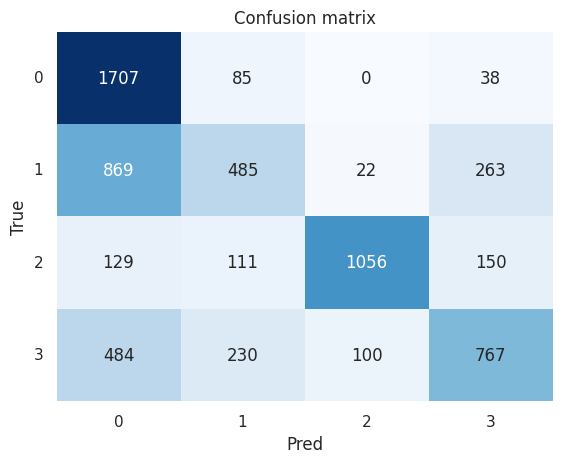

In [ ]:
model, accuracy, balanced_accuracy, cm = train_test_bi_lstm(model, X_train, X_test, y_train, y_test, epochs = 5)

## DistilBERT

In [37]:
aita_train["post_clean_bert"] = aita_train["post"].apply(lambda x: clean_text(x))
aita_test["post_clean_bert"] = aita_test["post"].apply(lambda x: clean_text(x))

In [38]:
X_train = get_X_tokenised_distilbert(aita_train["post_clean"], tokenizer_distil)
X_test = get_X_tokenised_distilbert(aita_test["post_clean"], tokenizer_distil)

In [ ]:
distilbert_model= get_distil_bert_model()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 512, 768),                                                   
                                 hidden_states=None                                           

Epoch 1/5
274/274 [==============================] - 135s 470ms/step - loss: 0.9979 - accuracy: 0.5530 - val_loss: 0.9417 - val_accuracy: 0.5890
Epoch 2/5
274/274 [==============================] - 127s 465ms/step - loss: 0.9142 - accuracy: 0.5973 - val_loss: 0.8909 - val_accuracy: 0.5998
Epoch 3/5
274/274 [==============================] - 127s 465ms/step - loss: 0.8883 - accuracy: 0.6052 - val_loss: 0.8952 - val_accuracy: 0.6018
Epoch 4/5
274/274 [==============================] - 127s 465ms/step - loss: 0.8743 - accuracy: 0.6119 - val_loss: 0.8842 - val_accuracy: 0.6065
Epoch 5/5
203/203 [==============================] - 36s 172ms/step


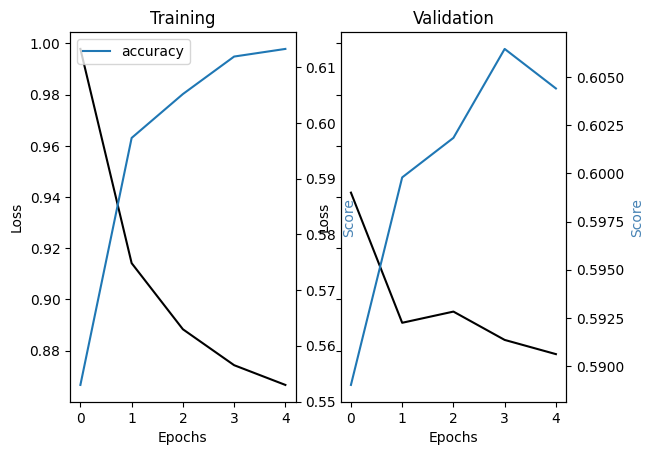

Accuracy: 0.61
Balanced accuracy: 0.6
Auc: 0.83
Detail:
              precision    recall  f1-score   support

           0       0.55      0.81      0.66      1830
           1       0.46      0.42      0.44      1639
           2       0.88      0.73      0.80      1446
           3       0.64      0.44      0.52      1581

    accuracy                           0.61      6496
   macro avg       0.63      0.60      0.60      6496
weighted avg       0.62      0.61      0.60      6496



(<keras.engine.functional.Functional at 0x7ff5d17284f0>,
 0.6052955665024631,
 0.6013809840189163,
 array([[1488,  303,    0,   39],
        [ 704,  693,   16,  226],
        [ 114,  150, 1051,  131],
        [ 393,  366,  122,  700]]))

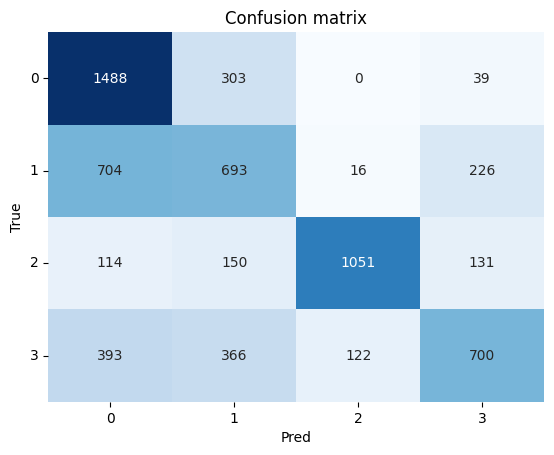

In [ ]:
train_test_distil_bert(distilbert_model, X_train, X_test, y_train, y_test, epochs = 5)